In [142]:
import os
import numpy as np
import pandas as pd
import gc

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import decomposition, preprocessing
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# debug
debug = False
if not debug:
    num_rows = None
else:
    num_rows = 10000
    
def str_to_datetime(strg):
    return datetime.strptime(strg, '%Y-%m-%d %H:%M:%S')
    

# Présentation du jeu de données

**Ce diagramme présente les relations entre les données:**

![image](https://i.imgur.com/HRhd2Y0.png)

L'objectif est de segmenter les clients. Cependant, la base de donnée "customers" contient non pas une ligne par client mais une ligne par commande. On va donc créer notre propre dataframe a partir du jeu de données fourni.

# Analyse exploratoire & Feature engineering

On traite d'abord le fichier client qui associe les IDs client uniques et non uniques. On génère une colonne "nombre de commandes", et une table d'association pour les IDs.

In [143]:
app_customers = pd.read_csv('./data/olist_customers_dataset.csv', nrows=num_rows)
app_aggs = {'customer_id': ['count']}
app = app_customers.groupby('customer_unique_id').agg({**app_aggs})
app.columns = pd.Index(["orders_count"])

# make hash table: customers ids => customer unique ids
cid_to_ucid = pd.DataFrame(data=app_customers[['customer_id', 'customer_unique_id']])
cid_to_ucid = cid_to_ucid.set_index('customer_id')



On traite le fichier des commandes. On ne conserve que les commandes délivrées avec succès (les autres représentant des cas particulier et non des tendances de consommation). Les variables extraites sont le temps de livraison, le delai de paiement, et l'erreur de prediction pour la date de livraison. On génère également une table d'association entre l'ID des commandes et l'ID unique des clients. 

In [144]:
app_orders = pd.read_csv('./data/olist_orders_dataset.csv', nrows=num_rows)
app_orders = app_orders.join(cid_to_ucid, how='left', on='customer_id')
# only keep delivered orders with non NaN timestamps
app_orders = app_orders[app_orders["order_status"]=="delivered"]
app_orders = app_orders[app_orders["order_delivered_customer_date"].isnull()==False]
app_orders = app_orders[app_orders["order_approved_at"].isnull()==False]
app_orders = app_orders[app_orders["order_purchase_timestamp"].isnull()==False]
app_orders = app_orders[app_orders["order_estimated_delivery_date"].isnull()==False]
# convert timestamps to datetime
app_orders["order_delivered_customer_date"] = app_orders["order_delivered_customer_date"].apply(str_to_datetime)
app_orders["order_approved_at"] = app_orders["order_approved_at"].apply(str_to_datetime)
app_orders["order_purchase_timestamp"] = app_orders["order_purchase_timestamp"].apply(str_to_datetime)
app_orders["order_estimated_delivery_date"] = app_orders["order_estimated_delivery_date"].apply(str_to_datetime)
# create new features
app_orders["shipping_delay"] = app_orders["order_delivered_customer_date"] - app_orders["order_approved_at"]
app_orders["payment_delay"] = app_orders["order_approved_at"] - app_orders["order_purchase_timestamp"]
app_orders["delivery_estimation_error"] = app_orders["order_delivered_customer_date"] - app_orders["order_estimated_delivery_date"]
# convert new features to float
app_orders["shipping_delay"] = app_orders["shipping_delay"].apply(lambda x: x.total_seconds() / 86400) # days
app_orders["delivery_estimation_error"] = app_orders["delivery_estimation_error"].apply(lambda x: x.total_seconds() / 86400) # days
app_orders["payment_delay"] = app_orders["payment_delay"].apply(lambda x: x.total_seconds() / 60) # minutes
# add aggregation to main dataframe
orders_aggs = {
    'shipping_delay': ['mean'],
    'payment_delay': ['mean'],
    'delivery_estimation_error': ['mean'],
}
orders = app_orders.groupby('customer_unique_id').agg({**orders_aggs})
orders.columns = pd.Index([e[0] + "_" + e[1] for e in orders.columns.tolist()])
app = app.join(orders, how='left', on='customer_unique_id')
app = app.dropna()

# make hash table: order ids => customer unique ids
oid_to_cuid = pd.DataFrame(data=app_orders[['order_id', 'customer_unique_id']])
oid_to_cuid = oid_to_cuid.set_index('order_id')

On traite le fichier des notes et commentaires pour les commandes délivrées avec succès. On extrait les statistiques associées aux notes, la présence ou non de commentaire et le délai de leur publication.

In [145]:
app_reviews = pd.read_csv('./data/olist_order_reviews_dataset.csv', nrows=num_rows)
app_reviews = app_reviews.join(oid_to_cuid, how='left', on='order_id')
# only keep reviews corresponding to existing orders
app_reviews = app_reviews[app_reviews["order_id"].isin(app_orders["order_id"])]
# convert timestamps to datetime
app_reviews["review_creation_date"] = app_reviews["review_creation_date"].apply(str_to_datetime)
app_reviews["review_answer_timestamp"] = app_reviews["review_answer_timestamp"].apply(str_to_datetime)
# create new features
app_reviews['customer_left_message'] = 1 - app_reviews['review_comment_message'].isnull()
app_reviews['review_delay'] = app_reviews["review_answer_timestamp"] - app_reviews["review_creation_date"]
# convert to float
app_reviews["review_delay"] = app_reviews["review_delay"].apply(lambda x: x.total_seconds() / 86400) # days
# add aggregation to main dataframe
reviews_aggs = {
    'review_score': ['min', 'max', 'mean', 'count'],
    'customer_left_message': ['mean'],
    'review_delay': ['mean']
}
reviews = app_reviews.groupby('customer_unique_id').agg({**reviews_aggs})
reviews.columns = pd.Index([e[0] + "_" + e[1] for e in reviews.columns.tolist()])
app = app.join(reviews, how='left', on='customer_unique_id')

On traite le fichier des paiements. On extrait les types de paiements utilisés après avoir utilisé le one-hot encoding sur la colonne "payment_type", ainsi que le nombre total de mensualités et la valeur totale des paiements.

In [146]:
app_pay = pd.read_csv('./data/olist_order_payments_dataset.csv', nrows=num_rows)
app_pay = app_pay.join(oid_to_cuid, how='left', on='order_id')
# only keep payments corresponding to existing orders
app_pay = app_pay[app_pay["order_id"].isin(app_orders["order_id"])]
# one-hot encoding
app_pay = pd.get_dummies(app_pay, prefix=['payment_type'], columns=['payment_type'])
# add aggregation to main dataframe
pay_aggs = {
    'payment_type_credit_card': ['max'],
    'payment_type_boleto': ['max'],
    'payment_type_debit_card': ['max'],
    'payment_type_voucher': ['max'],
    'payment_installments': ['sum'],
    'payment_value': ['sum']
}
payments = app_pay.groupby('customer_unique_id').agg({**pay_aggs})
payments.columns = pd.Index([e[0] + "_" + e[1] for e in payments.columns.tolist()])
app = app.join(payments, how='left', on='customer_unique_id')

app.head()

,orders_count,shipping_delay_mean,payment_delay_mean,delivery_estimation_error_mean,review_score_min,review_score_max,review_score_mean,review_score_count,customer_left_message_mean,review_delay_mean,payment_type_credit_card_max,payment_type_boleto_max,payment_type_debit_card_max,payment_type_voucher_max,payment_installments_sum,payment_value_sum
customer_unique_id,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,6.400914,14.850000,-4.132905,5,5,5.0,1,1.0,4.572778,1.0,0.0,0.0,0.0,8.0,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,1,2.984005,434.283333,-4.248125,4,4,4.0,1,0.0,0.937095,1.0,0.0,0.0,0.0,1.0,27.19
0000f46a3911fa3c0805444483337064,1,25.731759,0.000000,-1.389734,3,3,3.0,1,0.0,1.055370,1.0,0.0,0.0,0.0,8.0,86.22
0000f6ccb0745a6a4b88665a16c9f078,1,20.023472,19.600000,-11.108970,4,4,4.0,1,1.0,1.012396,1.0,0.0,0.0,0.0,4.0,43.62
0004aac84e0df4da2b147fca70cf8255,1,13.126435,21.166667,-7.035463,5,5,5.0,1,0.0,4.937211,1.0,0.0,0.0,0.0,6.0,196.89


On traite les fichiers relatifs aux produits et aux commandes. On extrait les valeurs moyennes et écart-types associés de la taille de la description, du nombre de photos, du poids, du volume, du prix et du montant des frais de ports de chaque produit pour chaque client. On réalise également un one-hot encoding sur les catégories (catégories générales nouvellement créées).

In [147]:
main_categories = {
    'culture': ['art', 'musical_instruments', 'cool_stuff', 'books_general_interest', 'audio', 'music', 'books_imported', 'dvds_blu_ray', 'arts_and_craftmanship', 'cine_photo', 'cds_dvds_musicals', 'sports_leisure'],
    'selfcare': ['perfumery', 'health_beauty', 'luggage_accessories', 'fashion_shoes', 'fashion_bags_accessories', 'watches_gifts', 'fashion_underwear_beach', 'fashion_male_clothing', 'fashio_female_clothing', 'fashion_sport', 'fashion_childrens_clothes', 'diapers_and_hygiene', 'flowers'], 
    'housecare': ['housewares', 'furniture_decor', 'home_appliances', 'office_furniture', 'stationery', 'furniture_living_room', 'air_conditioning', 'kitchen_dining_laundry_garden_furniture', 'home_appliances_2', 'party_supplies', 'home_confort', 'small_appliances_home_oven_and_coffee', 'christmas_supplies', 'furniture_bedroom', 'home_comfort_2', 'furniture_mattress_and_upholstery'], 
    'children': ['baby', 'toys', 'bed_bath_table', 'pet_shop'], 
    'electronics': ['computers_accessories', 'electronics', 'telephony', 'computers', 'small_appliances', 'consoles_games', 'fixed_telephony', 'tablets_printing_image'], 
    'labor': ['construction_tools_safety', 'garden_tools', 'auto', 'home_construction', 'construction_tools_construction', 'signaling_and_security', 'costruction_tools_tools', 'construction_tools_lights', 'books_technical', 'costruction_tools_garden'], 
    'work': ['agro_industry_and_commerce', 'industry_commerce_and_business', 'market_place', 'security_and_services'], 
    'food': ['drinks', 'la_cuisine', 'food_drink', 'food']}

def replace_cat(str_cat):
    for main_cat in main_categories:
        if str_cat in main_categories[main_cat]:
            return main_cat
    return 'unknown'

In [148]:
app_products = pd.read_csv('./data/olist_products_dataset.csv', nrows=num_rows)
# translate categories
app_translate = pd.read_csv('./data/product_category_name_translation.csv', nrows=num_rows)
app_products = app_products.set_index('product_category_name')
app_translate = app_translate.set_index('product_category_name')
app_products = app_products.join(app_translate, how='left', on='product_category_name')
app_products = app_products.set_index('product_id') # effectively drops the old categories column
# replace categories with wider ones
app_products["product_category_name_english"] = app_products["product_category_name_english"].apply(replace_cat)
app_products = app_products.rename(columns={'product_category_name_english':'category'})
# one-hot encoding
app_products = pd.get_dummies(app_products, prefix=['category'], columns=['category'])
# new feature
app_products["product_volume_m3"] = app_products["product_length_cm"] * app_products["product_height_cm"] * app_products["product_width_cm"] / 1000000
# drop useless data
for col in ['product_name_lenght', 'category_unknown', "product_length_cm", "product_height_cm", "product_width_cm"]:
    app_products = app_products.drop([col], axis=1)
    
app_products.head()

,product_description_lenght,product_photos_qty,product_weight_g,category_children,category_culture,category_electronics,category_food,category_housecare,category_labor,category_selfcare,category_work,product_volume_m3
product_id,,,,,,,,,,,,
1e9e8ef04dbcff4541ed26657ea517e5,287.0,1.0,225.0,0,0,0,0,0,0,1,0,0.002240
3aa071139cb16b67ca9e5dea641aaa2f,276.0,1.0,1000.0,0,1,0,0,0,0,0,0,0.010800
96bd76ec8810374ed1b65e291975717f,250.0,1.0,154.0,0,1,0,0,0,0,0,0,0.002430
cef67bcfe19066a932b7673e239eb23d,261.0,1.0,371.0,1,0,0,0,0,0,0,0,0.002704
9dc1a7de274444849c219cff195d0b71,402.0,4.0,625.0,0,0,0,0,1,0,0,0,0.004420


In [149]:
app_items = pd.read_csv('./data/olist_order_items_dataset.csv', nrows=num_rows)
app_items = app_items.join(app_products, how='left', on='product_id')
app_items = app_items.join(oid_to_cuid, how='left', on='order_id')
# only keep items corresponding to existing orders
app_items = app_items[app_items["order_id"].isin(app_orders["order_id"])]
# add aggregation to main dataframe
items_aggs = {
    'product_description_lenght': ['mean'],
    'product_photos_qty': ['mean'],
    'product_weight_g': ['mean'],
    'product_volume_m3': ['mean'],
    'category_children': ['max'],
    'category_culture': ['max'],
    'category_electronics': ['max'],
    'category_food': ['max'],
    'category_labor': ['max'],
    'category_housecare': ['max'],
    'category_selfcare': ['max'],
    'category_work': ['max'],
}
items = app_items.groupby('customer_unique_id').agg({**items_aggs})
items.columns = pd.Index([e[0] + "_" + e[1] for e in items.columns.tolist()])
app = app.join(items, how='left', on='customer_unique_id')

app.head()

,orders_count,shipping_delay_mean,payment_delay_mean,delivery_estimation_error_mean,review_score_min,review_score_max,review_score_mean,review_score_count,customer_left_message_mean,review_delay_mean,...,product_weight_g_mean,product_volume_m3_mean,category_children_max,category_culture_max,category_electronics_max,category_food_max,category_labor_max,category_housecare_max,category_selfcare_max,category_work_max
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,6.400914,14.850000,-4.132905,5,5,5.0,1,1.0,4.572778,...,1500.0,0.007616,1,0,0,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,2.984005,434.283333,-4.248125,4,4,4.0,1,0.0,0.937095,...,375.0,0.005148,0,0,0,0,0,0,1,0
0000f46a3911fa3c0805444483337064,1,25.731759,0.000000,-1.389734,3,3,3.0,1,0.0,1.055370,...,1500.0,0.043750,0,0,0,0,0,1,0,0
0000f6ccb0745a6a4b88665a16c9f078,1,20.023472,19.600000,-11.108970,4,4,4.0,1,1.0,1.012396,...,150.0,0.001045,0,0,1,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,1,13.126435,21.166667,-7.035463,5,5,5.0,1,0.0,4.937211,...,6050.0,0.000528,0,0,1,0,0,0,0,0


In [150]:
# cleaning
del app_customers, app_orders, app_reviews, app_pay, app_products, app_translate, app_items, orders, reviews, payments, items, cid_to_ucid, oid_to_cuid
gc.collect()

15

### Traitement des valeurs manquantes

In [151]:
print(f"Taille du jeu de données final: {app.shape}\n")
for col in app.columns.tolist():
    print(f"{col}: {app[col].isnull().sum()}")

app = app.drop(['830d5b7aaa3b6f1e9ad63703bec97d23']) # delete only wrong payment row (wrong usercase / user abuse)

Taille du jeu de données final: (93337, 28)

orders_count: 0
shipping_delay_mean: 0
payment_delay_mean: 0
delivery_estimation_error_mean: 0
review_score_min: 0
review_score_max: 0
review_score_mean: 0
review_score_count: 0
customer_left_message_mean: 0
review_delay_mean: 0
payment_type_credit_card_max: 1
payment_type_boleto_max: 1
payment_type_debit_card_max: 1
payment_type_voucher_max: 1
payment_installments_sum: 1
payment_value_sum: 1
product_description_lenght_mean: 1259
product_photos_qty_mean: 1259
product_weight_g_mean: 13
product_volume_m3_mean: 13
category_children_max: 0
category_culture_max: 0
category_electronics_max: 0
category_food_max: 0
category_labor_max: 0
category_housecare_max: 0
category_selfcare_max: 0
category_work_max: 0


Les seules autres valeurs manquantes sont dans les colonnes contenant des statistiques relatives à la description des produits. 

<AxesSubplot:xlabel='product_description_lenght_mean', ylabel='Count'>

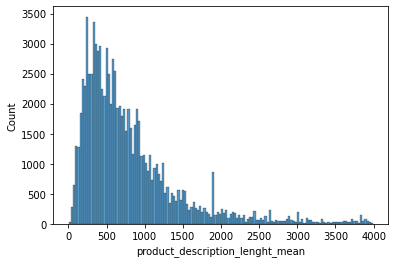

In [152]:
sns.histplot(data=app, x="product_description_lenght_mean")

Il n'existe quasiment aucune description vide donc les NaN sont probablement les descriptions manquantes. On impute les valeurs manquantes par 0.

In [153]:
app = app.fillna(0)
for col in app.columns.tolist():
    print(f"{col}: {app[col].isnull().sum()}")

orders_count: 0
shipping_delay_mean: 0
payment_delay_mean: 0
delivery_estimation_error_mean: 0
review_score_min: 0
review_score_max: 0
review_score_mean: 0
review_score_count: 0
customer_left_message_mean: 0
review_delay_mean: 0
payment_type_credit_card_max: 0
payment_type_boleto_max: 0
payment_type_debit_card_max: 0
payment_type_voucher_max: 0
payment_installments_sum: 0
payment_value_sum: 0
product_description_lenght_mean: 0
product_photos_qty_mean: 0
product_weight_g_mean: 0
product_volume_m3_mean: 0
category_children_max: 0
category_culture_max: 0
category_electronics_max: 0
category_food_max: 0
category_labor_max: 0
category_housecare_max: 0
category_selfcare_max: 0
category_work_max: 0


# Classification non supervisée

In [156]:
kmeans = KMeans(n_clusters = 10).fit(app)
kmeans.labels_
kmeans.cluster_centers_

array([[ 1.03408617e+00,  1.16485734e+01,  1.03568249e+02,
        -1.14038303e+01,  4.15319159e+00,  4.17619363e+00,
         4.16468780e+00,  1.03764192e+00,  3.96772440e-01,
         3.06574676e+00,  8.75892003e-01,  9.04141838e-02,
         1.78768484e-02,  4.32085142e-02,  2.80293779e+00,
         1.15176113e+02,  5.82064330e+02,  2.12950455e+00,
         4.22982851e+02,  5.84032441e-03,  1.54662939e-01,
         1.13784056e-01,  2.25312048e-01,  1.17707644e-02,
         6.68726550e-02,  1.27859928e-01,  2.95495230e-01,
         3.94811055e-03],
       [ 1.02574442e+00,  1.41945713e+01,  6.77553668e+02,
        -1.12136953e+01,  4.01736973e+00,  4.03411911e+00,
         4.02610629e+00,  1.02636476e+00,  4.48304384e-01,
         3.21847815e+00,  7.82878412e-01,  1.99751861e-01,
         1.11662531e-02,  2.82258065e-02,  4.27636476e+00,
         3.19385918e+02,  8.31435876e+02,  2.40994624e+00,
         1.07778337e+04,  5.52067731e-02,  2.09057072e-01,
         8.49875931e-02,  4.06

# Résultats

In [155]:
# app_embedded = TSNE(n_components=2).fit_transform(app)